# Libraries

In [4]:
# import csv
# import os
import re
import json
import umap

import hdbscan

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors
from IPython.display import clear_output
from pointgrid import align_points_to_grid

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# import math
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy import interpolate


# Import

## Dataset

In [62]:
query = "Query_AI-magazines-mediacloud-2021-24"

FEATHER_FILE = query + ".feather"
df = pd.read_feather('data/' + FEATHER_FILE)


# Drop rows where the 'Name' column has an empty string
df = df[df['text'] != '']

df = df.drop('text_downloaded', axis=1)
df = df.drop('indexed_date', axis=1)
df = df.drop('language', axis=1)
df = df.drop('media_url', axis=1)
df = df.drop('id', axis=1)


df = df.reset_index(drop=True)

# df.sample(1)
df.iloc[[1]]
# df['A'] = df['A'].apply(lambda x: list(set(x)))

,media_name,publish_date,title,url,year,text,GPE,IND,ORG
1,technologyreview.com,2024-09-10,What impact will AI have on video game develop...,https://www.technologyreview.com/2024/09/10/11...,2024,What impact will AI have on video game develop...,"[AI, LA, Netherlands, new AI]","[Midjourney, BAM, Niall, Bits, Josh Kahn, Alph...","[Algorithm, AI, inbox, crunch”—essentially, Ub..."


## Cleaning

In [64]:
df['GPE'] = df['GPE'].apply(lambda x: list(set(x)) if isinstance(x, list) else x)
df['IND'] = df['IND'].apply(lambda x: list(set(x)) if isinstance(x, list) else x)
df['ORG'] = df['ORG'].apply(lambda x: list(set(x)) if isinstance(x, list) else x)

df.iloc[[1]]

,media_name,publish_date,title,url,year,text,GPE,IND,ORG
1,technologyreview.com,2024-09-10,What impact will AI have on video game develop...,https://www.technologyreview.com/2024/09/10/11...,2024,What impact will AI have on video game develop...,"[AI, LA, Netherlands, new AI]","[Midjourney, BAM, Niall, Bits, Josh Kahn, Alph...","[Algorithm, AI, inbox, crunch”—essentially, Ub..."


## Years

In [65]:
df = df[pd.to_numeric(df['year'], errors='coerce').notnull()] # Remove cells without integer
df = df.reset_index(drop=True)

print(set(df["year"].tolist()))

{2024, 2021, 2022, 2023}


## Entities

In [68]:
entities = np.empty((0, 12), dtype=object)

years_template = {}

for year in sorted(set(df["year"].tolist())):
    years_template[year] = 0


def update(entity, type):  # Function for writing

    global entities
    co = cooccurrences.copy()
    co.remove(entity)
    index = np.where(entities[:, 0] == entity)[0]

    if index.size == 0:
        entities = np.append(
            entities,
            np.array(
                [
                    [
                        entity,
                        type,
                        1,
                        None,
                        None,
                        -1,
                        -1,
                        -1,
                        years_template.copy(),
                        [url],
                        [title],
                        co,
                    ]
                ],
                dtype=object,
            ),
            axis=0,
        )
        entities[len(entities) - 1][8][year] = 1  # Add year
    else:
        entities[index, 2] += 1  # Frequency
        entities[index, 8][0][year] += 1  # Year
        entities[index, 9][0].append(url)  # URL
        entities[index, 10][0].append(title)  # Title
        entities[index, 11][0] += co  # Co-occurrences


for index, row in df.iterrows():  # Iteration on all the articles

    url = row["url"]
    year = row["year"]
    title = row["title"]

    gpe = row["GPE"]
    ind = row["IND"]
    org = row["ORG"]
    # tag = row["TAG"]
    
    cooccurrences = list(gpe) + list(ind) + list(org)
    # cooccurrences = list(gpe + ind + org + tag)

    for entity in gpe:
        update(entity, "gpe")
    
    for entity in ind:
        update(entity, "ind")

    for entity in org:
        update(entity, "org")

    # for entity in tag:
    #     update(entity, "tag")


# Numpy to Pandas

entities_all = pd.DataFrame(
    entities,
    columns=[
        "name",
        "type",
        "frequency",
        "slope",
        "color",
        "x",
        "y",
        "cluster",
        "years",
        "urls",
        "titles",
        "cooccurrences",
    ],
)  # Dataset
entities_all = entities_all.astype(
    {
        "name": "str",
        "type": "str",
        "frequency": "int",
        "slope": "float",
        "color": "str",
        "x": "int",
        "y": "int",
        "cluster": "int",
        "years": "object",
        "urls": "object",
        "titles": "object",
        "cooccurrences": "object",
    }
)


print("The total number of entities is", len(entities))

entities_all.sort_values(by=["frequency"], ascending=False).head(1)

The total number of entities is 23798


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences
15,AI,org,3429,NaN,None,-1,-1,-1,"{2021: 485, 2022: 212, 2023: 1560, 2024: 1172}",[https://www.technologyreview.com/2024/09/10/1...,[2024 Innovator of the Year: Shawn Shan builds...,"[Shawn Shan, Shan, Shawn Shan, Midjourney, Sha..."


# Treatment

## Normalization

In [69]:
# Frequency scale

frequency = entities_all["frequency"].to_numpy().reshape(-1, 1)
min_max_scaler = preprocessing.MinMaxScaler()
frequency_scaled = min_max_scaler.fit_transform(frequency)
entities_all["frequency_norm"] = frequency_scaled

# Transfrom dictionary into JSON

for index, row in entities_all.iterrows():
    entities_all.loc[index, "years_JSON"] = json.dumps(row["years"])

entities_all.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
5401,Philadelphia Inquirer,org,1,NaN,None,-1,-1,-1,"{2021: 0, 2022: 0, 2023: 0, 2024: 1}",[https://www.wired.com/story/death-of-truth-mi...,[You Think You Know How Misinformation Spreads...,"[Buffett, Russia, Moscow, Walmart, US, US, San...",0.0,"{""2021"": 0, ""2022"": 0, ""2023"": 0, ""2024"": 1}"


## Filter Entities

In [79]:

# counting

len_gpe = entities_all.loc[(entities_all["type"] == "gpe")].shape[0]
len_ind = entities_all.loc[(entities_all["type"] == "ind")].shape[0]
len_org = entities_all.loc[(entities_all["type"] == "org")].shape[0]
# len_tag = entities_all.loc[(entities_all["type"] == "tag")].shape[0]

print(len_gpe, len_ind, len_org)


# max_gpe = 0
# max_ind = 100
# max_org = 0
# max_tag = 100

min_frequency = 30



top_gpe = (
    entities_all.loc[
        (entities_all["type"] == "gpe")
        & (entities_all["frequency"] > min_frequency)
    ]
    .sort_values(by=["frequency"], ascending=False)
    # .head(max_gpe)
)
top_ind = (
    entities_all.loc[
        (entities_all["type"] == "ind")
        & (entities_all["frequency"] > min_frequency)
    ]
    .sort_values(by=["frequency"], ascending=False)
    # .head(max_ind)
)
top_org = (
    entities_all.loc[
        (entities_all["type"] == "org")
        & (entities_all["frequency"] > min_frequency)
    ]
    .sort_values(by=["frequency"], ascending=False)
    # .head(max_org)
)
# top_tag = (
#     entities_all.loc[
#         (entities_all["type"] == "tag")
#         & (entities_all["frequency"] > min_frequency * .5)
#     ]
#     .sort_values(by=["frequency"], ascending=False)
#     # .head(max_tag)
# )

entities = pd.concat([top_gpe, top_ind, top_org])

len(entities) # 400 is a good number for the map

1570 11945 10283


390

In [80]:
entities.sample(3)

,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
20006,Lynch,gpe,37,NaN,None,-1,-1,-1,"{2021: 31, 2022: 6, 2023: 0, 2024: 0}",[https://www.wired.com/story/hidden-role-facia...,[The Hidden Role of Facial Recognition Tech in...,"[Bronx, US, US, US, Georgetown, New York, US, ...",0.010502,"{""2021"": 31, ""2022"": 6, ""2023"": 0, ""2024"": 0}"
2503,Copilot,org,72,NaN,None,-1,-1,-1,"{2021: 8, 2022: 11, 2023: 38, 2024: 15}",[https://www.theverge.com/24201441/ai-terminol...,"[AI terminology, explained for humans, Surface...","[Georgetown, Seattle, Mark Zuckerberg, Bias, J...",0.020712,"{""2021"": 8, ""2022"": 11, ""2023"": 38, ""2024"": 15}"
348,Texas,gpe,99,NaN,None,-1,-1,-1,"{2021: 2, 2022: 11, 2023: 39, 2024: 47}",[https://www.wired.com/story/confidant-health-...,[Therapy Sessions Exposed by Mental Health Car...,"[US, Connecticut, Florida, Jeremiah Fowler, Fo...",0.028588,"{""2021"": 2, ""2022"": 11, ""2023"": 39, ""2024"": 47}"


## Linear Regression

In [81]:
# For each entity

for i, row in entities.iterrows():

    x = list(row["years"].keys()) # Extract years
    x = [int(numeric_string) for numeric_string in x] # Set to int
    x = np.array(x).reshape((-1, 1))  # Needed for one-column values
    y = list(row["years"].values()) # Extract frequency
    y = np.array(y) # To Numpy (code works without this line)

    regression = LinearRegression()
    regression.fit(x, y)
    
    entities.at[i, "slope"] = regression.coef_[0] # compute linear regression


# normalization by type

scale = 1

for type in entities["type"].unique():

    selection = entities.loc[entities["type"] == type]
    mean = selection["slope"].mean() * scale
    
    for i, row in selection.iterrows():
        entities.at[i, "slope"] = row["slope"] - mean


entities.sample()


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
594,Covid,ind,49,-7.718605,None,-1,-1,-1,"{2021: 8, 2022: 12, 2023: 18, 2024: 11}",[https://www.wired.com/story/big-interview-ant...,[Antony Blinken Dragged US Diplomacy Into the ...,"[US, America, Afghanistan, Ukraine, Russia, Is...",0.014002,"{""2021"": 8, ""2022"": 12, ""2023"": 18, ""2024"": 11}"


## Colors

In [82]:
import matplotlib.colors as mcolors

cmap = plt.cm.coolwarm
norm = matplotlib.colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

for i, row in entities.iterrows():

    if row["type"] == "tag":
        entities.at[i, "color"] = "#cccccc"
    else:
        entities.at[i, "color"] = mcolors.to_hex(cmap(norm(row["slope"])))  # Actors

# entities.sort_values(by=["slope"], ascending=False).head(1)
entities.head(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
110,US,gpe,2120,187.6225,#b40426,-1,-1,-1,"{2021: 277, 2022: 292, 2023: 763, 2024: 788}",[https://www.wired.com/story/crispr-enhanced-v...,[Crispr-Enhanced Viruses Are Being Deployed Ag...,"[North Carolina, Soviet Union, the Republic of...",0.618145,"{""2021"": 277, ""2022"": 292, ""2023"": 763, ""2024""..."


# Embedding

## Term Frequency

In [83]:
vectorizer = CountVectorizer(
    input="content",
    lowercase=False,
    # preprocessor=lambda x: x,
    tokenizer=lambda key: key,
)
words = entities["cooccurrences"].to_list()
X = vectorizer.fit_transform(words)

tfidf = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf.fit(X)
train_data = tfidf.transform(X)


/opt/homebrew/Caskroom/miniconda/base/envs/weathermap/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## UMAP

/opt/homebrew/Caskroom/miniconda/base/envs/weathermap/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


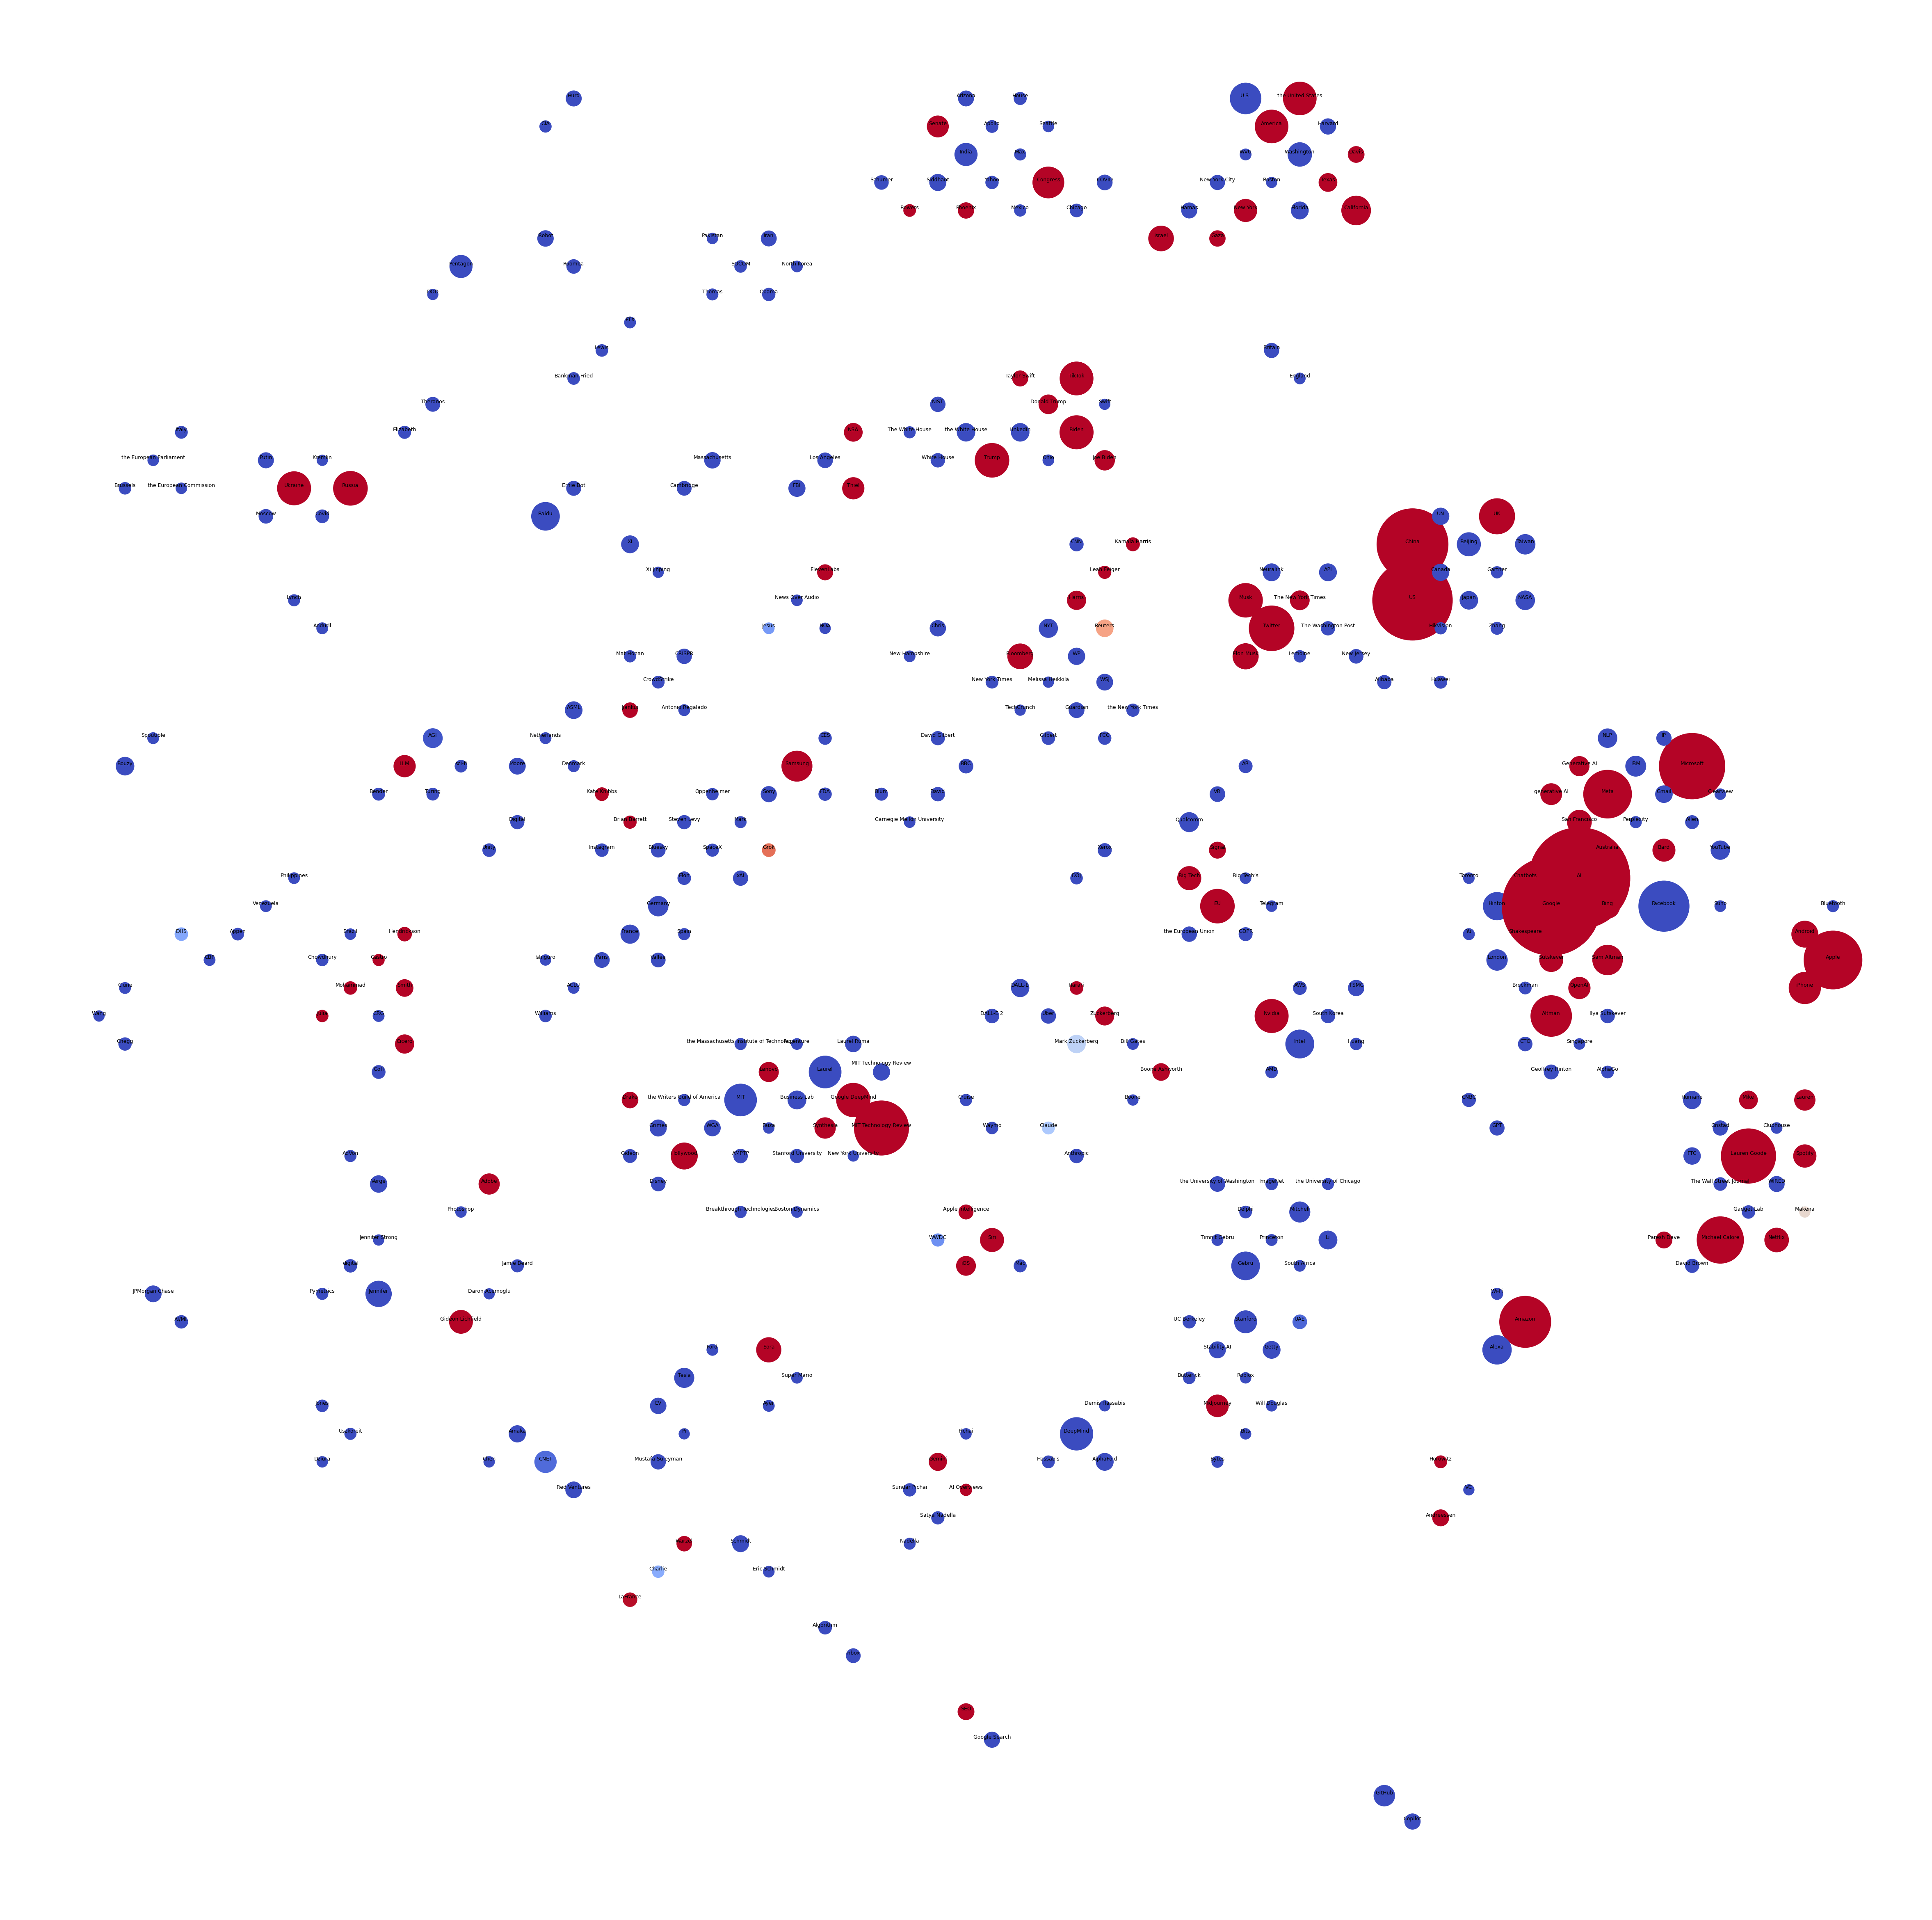

In [84]:
reducer = umap.UMAP(
    random_state=5,
    n_components=2,
    n_neighbors=2,
    min_dist=0.1,
    metric="hellinger",
)

embedding = reducer.fit_transform(train_data)  # Reducer
embedding = align_points_to_grid(embedding)  # Alignment to a grid

scaler = MinMaxScaler(feature_range=(100, 900))  # Scale
embedding = scaler.fit_transform(embedding)
embedding = embedding.astype(int)

index_embedding = 0  # Writing values in the dataset
for index, row in entities.iterrows():
    entities.loc[index, "x"] = embedding[:, 0][index_embedding]
    entities.loc[index, "y"] = embedding[:, 1][index_embedding]
    index_embedding += 1

# entities.sample(1)

plt.figure(figsize=(20, 20), dpi=300)
plt.axis("off")

# Scatterplot

plt.scatter(
    entities["x"].to_list(),
    entities["y"].to_list(),
    s=entities["frequency"].to_list(),
    c=entities["color"].to_list(),
)

# Labels

for i, row in entities.iterrows():
    text = plt.annotate(row["name"], xy=(row["x"], row["y"]), ha="center", va="bottom")
    text.set_fontsize(3)

plt.savefig("download.png")


## Clustering

In [85]:
clusterer = hdbscan.HDBSCAN(
    # min_samples=3,
    min_cluster_size=3,
    # cluster_selection_epsilon=50,   # float, optional (default=0.0) A distance threshold. Clusters below this value will be merged.
    # gen_min_span_tree=False,
    # leaf_size=5, # int, optional (default=40) If using a space tree algorithm (kdtree, or balltree) the number of points ina leaf node of the tree. This does not alter the resulting clustering, but may have an effect on the runtime of the algorithm.
)

entities["cluster"] = "-1"  # Reset


def cluster_computing(rows, prefix, entities):

    embedding = rows[["x", "y"]].to_numpy()
    clusterer.fit(embedding)
    clusters = clusterer.labels_

    # Write cluster number

    for count, (index, row) in enumerate(rows.iterrows()):
        if clusters[count] != -1:
            entities.loc[index, "cluster"] = prefix + str(clusters[count])
        else:
            entities.loc[index, "cluster"] = str(clusters[count])
    

cluster_computing(
    entities.loc[(entities["type"] != "tag") & (entities["slope"] > 0)],
    "p_",
    entities,
)
cluster_computing(
    entities.loc[(entities["type"] != "tag") & (entities["slope"] < 0)],
    "n_",
    entities,
)

entities.sample(1)

,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
1213,ACLU,org,33,-8.254144,#3b4cc0,319,487,n_21,"{2021: 3, 2022: 2, 2023: 6, 2024: 22}",[https://www.technologyreview.com/2024/08/16/1...,"[What’s next for drones, Steve Jobs Knew the M...","[Ukraine, Gaza, US, Arizona, Scottsdale, Scott...",0.009335,"{""2021"": 3, ""2022"": 2, ""2023"": 6, ""2024"": 22}"


{'p_5', 'n_19', 'n_8', 'n_21', 'n_3', 'n_0', 'n_20', 'p_6', 'n_6', 'n_17', 'n_16', 'p_8', 'p_1', 'p_7', 'n_13', 'n_2', 'p_3', 'n_14', 'n_15', 'n_18', 'n_9', 'p_0', 'n_5', 'n_1', 'n_10', 'p_4', 'n_7', 'p_2', '-1', 'n_11', 'n_4', 'n_12'}
7
7
10
18
14
12
11
12
9
10
7
11
10
6
20
6
8
3
4
4
18
14
13
16
9
6
10
8
75
9
10
13


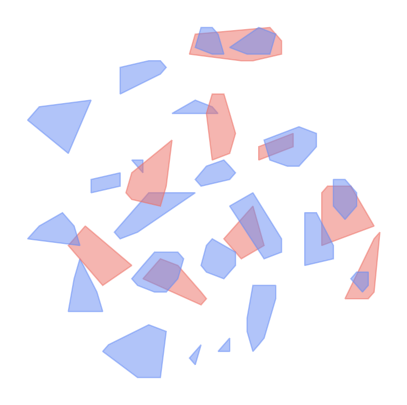

In [86]:
plt.figure(figsize=(5, 5))
plt.axis("off")

clusters = set(entities["cluster"].tolist())

print(clusters)

for counter, cluster in enumerate(clusters):

    points = []  # Points
    rows = entities.loc[entities["cluster"] == cluster]  # Rows

    for index, row in rows.iterrows():
        points.append([row["x"], row["y"]])
    points = np.array(points)

    print(len(points))

    hull = ConvexHull(points)  # Hull
    x_hull = np.append(points[hull.vertices, 0], points[hull.vertices, 0][0])
    y_hull = np.append(points[hull.vertices, 1], points[hull.vertices, 1][0])

    if cluster[0] == "p":
        plt.fill(x_hull, y_hull, "--", c="#ED6D62", alpha=0.5)  # Plot red
    elif cluster[0] == "n":
        plt.fill(x_hull, y_hull, "--", c="#648BF5", alpha=0.5)  # Plot blue


# Save

In [87]:
export = entities.copy()

export = export.drop(columns="years")
export = export.drop(columns="titles")
export = export.drop(columns="cooccurrences")


export.to_csv("src/data/entities.csv", index=False)

export.sample(1)


,name,type,frequency,slope,color,x,y,cluster,urls,frequency_norm,years_JSON
71,Apple,org,1113,200.545856,#b40426,900,500,p_1,[https://www.wired.com/story/which-apple-iphon...,0.324387,"{""2021"": 82, ""2022"": 62, ""2023"": 225, ""2024"": ..."
